In [264]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import os
import random
from statsmodels.stats.proportion import binom_test
from statsmodels.stats.multitest import multipletests

def parse_genome(df):
    genome_id = df['#query'][0].split('_')[0]
    keggs = df['KEGG_ko'].replace('-', None).dropna()
    keggs = list(map(lambda x: x.split(','), keggs.values))
    keggs = sum(keggs, [])
    keggs = pd.DataFrame({'KEGG_ko': keggs})
    keggs['genome_id'] = genome_id
    return keggs

def to_sparse_matrix(func_df, genome_id='genome_id', kegg_id='KEGG_ko'):
    # create genome-specific index
    ogus = list(set(func_df[genome_id]))
    ogu_lookup = pd.Series(np.arange(0, len(ogus)), ogus)
    # create KEGG-specific index
    keggs = list(set(func_df[kegg_id]))
    kegg_lookup = pd.Series(np.arange(0, len(keggs)), keggs)
    # rename names as numbers
    ogu_id = func_df[genome_id].apply(lambda x: ogu_lookup.loc[x]).astype(np.int64)
    kegg_id = func_df[kegg_id].apply(lambda x: kegg_lookup.loc[x]).astype(np.int64)
    # assign the presence / absence of a gene
    func_df['count'] = 1
    c = func_df['count'].values
    # format into a matrix
    data = coo_matrix((c, (ogu_id, kegg_id)))
    ko_ogu = pd.DataFrame(data.todense(), index=ogus, columns=keggs)
    return ko_ogu

def btest(pa1, pa2, seed=0, return_proportions=False):
    """ Performs genome wide binomial test between two groups of taxa
    Parameters
    ----------
    df1 : pd.DataFrame
        Rows are taxa, columns are genes
    df2 : pd.DataFrame
        Rows are taxa, columns are genes
    Returns
    -------
    pd.Series : list of genes associated with df1
    pd.Series : list of genes associated with df2
    """
    np.random.seed(seed)
    random.seed(seed)
    #pa1 = df1 > 0
    #pa2 = df2 > 0
    idx = list(set(pa1.columns) | set(pa2.columns))
    idx.sort()
    pa1 = pa1.sum(axis=0).reindex(idx).fillna(0)
    pa2 = pa2.sum(axis=0).reindex(idx).fillna(0)
    n = pa1 + pa2
    obs = list(zip(list(pa1.values), list((pa2.values + 1) / (pa2 + 1).sum()), list(n.values)))
    pvals = pd.Series([binom_test(a, n, b, 'two-sided') for (a, b, n) in obs],
                      index=n.index)
    if return_proportions:
        res = pd.DataFrame({'groupA': pa1, 'groupB': pa2, 'pval': pvals})
        def relabel_f(x):
            if x['groupA'] < x['groupB']:
                return 'groupB'
            else:
                return 'groupA'
        res['side'] = res.apply(relabel_f, axis=1)
        return res

    return pvals

def log_pvalue(lr, alpha=0.1, filter=True):
    """ Converts pvalues to -log(pvalue)
    Also performs Boniferroni correction.
    """
    lr = lr.reset_index()
    # lr.columns = ['KEGG', 'pvalue']
    lr['-log(pvalue)'] = -np.log(lr['pvalue'] + 1e-200)
    res = multipletests(lr['pvalue'], method='fdr_bh', alpha=alpha)
    lr['pvalue_corrected'] = res[1]
    if filter:
        lr = lr.loc[res[0]]
        return lr
    return lr

In [47]:
#run only once to generate two columns file metadata_new 
# #parse genomes-all_metadata.tsv: get species names from Lineage and Species_rep
# metadata = pd.read_table('../../../../Downloads/genomes-all_metadata.tsv')
# metadata_new = metadata[['Lineage','Species_rep']]
# metadata_new['species'] = metadata_new['Lineage'].str.split(';').str[6]
# metadata_new['Species'] = metadata_new['species'].str.split('__').str[1]
# metadata_new = metadata_new[['Species','Species_rep']]
# metadata_new.to_csv('../table/eggNOG_species_rep.txt', sep = '\t', index = False)

In [95]:
metadata_new = pd.read_table('../table/eggNOG_species_rep.txt')

In [139]:
#load tables
table_t2d = pd.read_table('../table/QinT2D_deseq2_all.txt')
table_cd = pd.read_table('../table/Franzosa_CD_deseq2_all.txt')
table_asd = pd.read_table('../table/Dan_n_Wang_ASD_deseq2_all.txt')

#negative: more abundant in cases
table_t2d_negative = table_t2d.sort_values(by=['CI_95'],ascending=True).head(100)
table_cd_negative = table_cd.sort_values(by=['CI_95'],ascending=True).head(100)
table_asd_negative = table_asd.sort_values(by=['CI_95'],ascending=True).head(100)

#positive: more abundant in controls
table_t2d_positive = table_t2d.sort_values(by=['CI_5'],ascending=False).head(100)
table_cd_positive = table_cd.sort_values(by=['CI_5'],ascending=False).head(100)
table_asd_positive = table_asd.sort_values(by=['CI_5'],ascending=False).head(100)


In [257]:
t2d_positive = list(table_t2d_positive['Unnamed: 0'])
t2d_negative = list(table_t2d_negative['Unnamed: 0'])
asd_positive = list(table_asd_positive['Unnamed: 0'])
asd_negative = list(table_asd_negative['Unnamed: 0'])

In [258]:
t2d_positive_rep = metadata_new[metadata_new['Species'].isin(t2d_positive)]
Species_rep_ids_t2d_positive = t2d_positive_rep['Species_rep'].drop_duplicates()
t2d_negative_rep = metadata_new[metadata_new['Species'].isin(t2d_negative)]
Species_rep_ids_t2d_negative = t2d_negative_rep['Species_rep'].drop_duplicates()

asd_positive_rep = metadata_new[metadata_new['Species'].isin(asd_positive)]
Species_rep_ids_asd_positive = asd_positive_rep['Species_rep'].drop_duplicates()
asd_negative_rep = metadata_new[metadata_new['Species'].isin(asd_negative)]
Species_rep_ids_asd_negative = asd_negative_rep['Species_rep'].drop_duplicates()


In [175]:
Species_rep_ids_t2d_positive
Species_rep_ids_t2d_negative
#why length = 101?

6       MGYG000000007
7       MGYG000000008
20      MGYG000000021
45      MGYG000000046
79      MGYG000000080
            ...      
4395    MGYG000004424
4588    MGYG000004618
4775    MGYG000004805
4791    MGYG000004821
4831    MGYG000004861
Name: Species_rep, Length: 101, dtype: object

In [261]:
len(asd_negative)

100

In [262]:
eggNOG_dir

'http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue'

In [177]:
mkdir T2D_negative
mkdir T2D_positive

In [255]:
for i in Species_rep_ids_t2d_negative:
    os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O T2D_negative/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

In [266]:
!mkdir ASD_negative
!mkdir ASD_positive

In [256]:
#download the eggNOG tsv files
for i in Species_rep_ids_t2d_positive:
    os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O T2D_positive/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

In [270]:
for i in Species_rep_ids_asd_negative:
    os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O ASD_negative/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

In [269]:
for i in Species_rep_ids_asd_positive:
    os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O ASD_positive/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

In [272]:
#ASD
df_list_p = []
for i in Species_rep_ids_asd_positive:
    f_name = 'ASD_positive/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_p = to_sparse_matrix(df_cat_p)


df_list_n = []
for i in Species_rep_ids_asd_negative:
    f_name = 'ASD_negative/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_n.append(df_parsed)
    
df_cat_n = pd.concat(df_list_n, axis=0)
genome_kegg_counts_n = to_sparse_matrix(df_cat_n)
#clean up
!rm -r ASD_negative/
!rm -r ASD_positive/
#compare controls and cases: for top 100 microbes
kegg_asd = btest(genome_kegg_counts_p, genome_kegg_counts_n, return_proportions=False)
kegg_asd = pd.DataFrame({'pvalue': kegg_asd})
kegg_asd = kegg_asd.reset_index().rename(columns={'index': 'KEGG'})
kegg_asd = log_pvalue(kegg_asd, alpha=0.1)
kegg_asd.sort_values(by = ['pvalue'])

,index,KEGG,pvalue,-log(pvalue),pvalue_corrected
1181,1181,ko:K02005,0.000000,460.517019,0.000000
685,685,ko:K01190,0.000000,460.517019,0.000000
697,697,ko:K01206,0.000000,460.517019,0.000000
1258,1258,ko:K02103,0.000000,460.517019,0.000000
1249,1249,ko:K02078,0.000000,460.517019,0.000000
...,...,...,...,...,...
474,474,ko:K00844,0.000590,7.436122,0.000619
6282,6282,ko:K21140,0.000728,7.225467,0.000764
135,135,ko:K00197,0.000728,7.225467,0.000764
4174,4174,ko:K10234,0.001230,6.700979,0.001290


In [273]:
kegg_t2d.sort_values(by = ['pvalue']).head(50)

,index,pvalue,-log(pvalue),pvalue_corrected
1155,ko:K02078,0.0,460.517019,0.0
2786,ko:K06921,0.0,460.517019,0.0
397,ko:K00791,0.0,460.517019,0.0
1221,ko:K02238,0.0,460.517019,0.0
2859,ko:K07011,0.0,460.517019,0.0
2868,ko:K07025,0.0,460.517019,0.0
2913,ko:K07085,0.0,460.517019,0.0
394,ko:K00788,0.0,460.517019,0.0
2922,ko:K07098,0.0,460.517019,0.0
579,ko:K01091,0.0,460.517019,0.0


In [207]:
#T2D
df_list_p = []
for i in Species_rep_ids_t2d_positive:
    f_name = 'T2D_positive/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_p = to_sparse_matrix(df_cat_p)


df_list_n = []
for i in Species_rep_ids_t2d_negative:
    f_name = 'T2D_negative/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_n.append(df_parsed)
    
df_cat_n = pd.concat(df_list_n, axis=0)
genome_kegg_counts_n = to_sparse_matrix(df_cat_n)

In [254]:
!rm -r T2D_negative/
!rm -r T2D_positive/

In [224]:
#compare controls and cases: for top 100 microbes
kegg_t2d = btest(genome_kegg_counts_p, genome_kegg_counts_n, return_proportions=False)
kegg_t2d = pd.DataFrame({'pvalue': kegg_t2d})
kegg_t2d = kegg_t2d.reset_index().rename(columns={'index': 'KEGG'})
kegg_t2d = log_pvalue(kegg_t2d, alpha=0.1)

In [249]:
kegg_t2d.sort_values(by = ['pvalue'])

,index,pvalue,-log(pvalue),pvalue_corrected
1155,ko:K02078,0.000000,460.517019,0.000000
2786,ko:K06921,0.000000,460.517019,0.000000
397,ko:K00791,0.000000,460.517019,0.000000
1221,ko:K02238,0.000000,460.517019,0.000000
2859,ko:K07011,0.000000,460.517019,0.000000
...,...,...,...,...
1897,ko:K03492,0.023240,3.761895,0.032526
3713,ko:K09963,0.024038,3.728110,0.033636
3332,ko:K08161,0.028225,3.567542,0.039484
3606,ko:K09773,0.029101,3.536978,0.040700


In [286]:
kegg_t2d_sig = kegg_t2d.loc[(kegg_t2d['pvalue'] <= 0.001)]

In [289]:
kegg_t2d_sig.sort_values(by = ['pvalue_corrected'])

,index,pvalue,-log(pvalue),pvalue_corrected
2859,ko:K07011,0.000000,460.517019,0.000000
642,ko:K01209,0.000000,460.517019,0.000000
673,ko:K01262,0.000000,460.517019,0.000000
1400,ko:K02529,0.000000,460.517019,0.000000
1353,ko:K02470,0.000000,460.517019,0.000000
...,...,...,...,...
258,ko:K00483,0.000845,7.075844,0.001205
1509,ko:K02782,0.000845,7.075844,0.001205
691,ko:K01303,0.000845,7.075844,0.001205
166,ko:K00285,0.000845,7.075844,0.001205


In [290]:
kegg_t2d.loc[(kegg_t2d['pvalue_corrected'] <= 0.001)]

,index,pvalue,-log(pvalue),pvalue_corrected
0,ko:K00001,2.775592e-32,72.661859,6.347100e-32
1,ko:K00002,6.289484e-05,9.674046,9.381883e-05
2,ko:K00003,5.123586e-141,323.030643,2.781516e-140
3,ko:K00004,7.505432e-07,14.102469,1.244513e-06
4,ko:K00005,2.958079e-30,67.993013,6.622249e-30
...,...,...,...,...
5627,ko:K22432,6.792365e-98,223.737540,2.795167e-97
5628,ko:K22441,6.039021e-11,23.530194,1.082766e-10
5629,ko:K22445,3.442794e-32,72.446440,7.860094e-32
5633,ko:K22468,6.988462e-06,11.871250,1.093897e-05


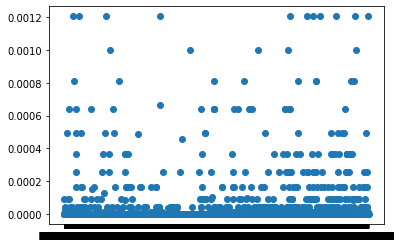

In [292]:
import matplotlib.pyplot as plt
x = kegg_t2d_sig['index']
y = kegg_t2d_sig['pvalue_corrected']
plt.scatter(x, y)
plt.show()

In [252]:
kegg_t2d.sort_values(by = ['pvalue']).head(50)

,index,pvalue,-log(pvalue),pvalue_corrected
1155,ko:K02078,0.0,460.517019,0.0
2786,ko:K06921,0.0,460.517019,0.0
397,ko:K00791,0.0,460.517019,0.0
1221,ko:K02238,0.0,460.517019,0.0
2859,ko:K07011,0.0,460.517019,0.0
2868,ko:K07025,0.0,460.517019,0.0
2913,ko:K07085,0.0,460.517019,0.0
394,ko:K00788,0.0,460.517019,0.0
2922,ko:K07098,0.0,460.517019,0.0
579,ko:K01091,0.0,460.517019,0.0
